In [1]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
import tensorflow as tf
from sklearn import preprocessing
import numpy as np
import random
import matplotlib.pyplot as plt
import sys
from  numba  import njit, prange
from Model.CNN import cnn_classifier
from utils.LoadData import load_CW_Source,load_CW_Target
from Skinny import *

d:\VirtualEnvironment\Anaconda3\envs\TF-krease\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\VirtualEnvironment\Anaconda3\envs\TF-krease\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
d:\VirtualEnvironment\Anaconda3\envs\TF-krease\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
d:\VirtualEnvironment\Anaconda3\envs\TF-krease\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
d:\VirtualEnvironment\Anaconda3\envs\TF-krease\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
def round_function_revesal(c, tweakey):
    # Convert inputs to numpy arrays for efficient bitwise operations
    tweakey_tmp = np.array(tweakey, dtype=np.int32)
    c_tmp = np.array(c, dtype=np.int32)
    
    # Cryptographic inverse mixing operation (e.g., Inverse MixColumns in AES-like ciphers)
    Inv_mix_columns(c_tmp)
    
    # Reverse key addition/modification step (Tweakey XOR with state)
    addRoundTweakey(c_tmp, tweakey_tmp)
    
    # Store final processed state
    V = np.array(c_tmp)
    
    return V

def plot_guessing_entropy(preds, real_key, c_attack,updatedTweak):
    ## key is unkonw
    key=np.array([ 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00]) #/* tweakey */
    # GE/SR is averaged over 20 attacks
    num_averaged = 20
    # max trace num for attack
    trace_num_max = 2000
    #tweak Permutation
    tkP_index=2

    guessing_entropy = np.zeros((num_averaged, trace_num_max))
    success_flag = np.zeros((num_averaged, trace_num_max))
    

    # attack multiples times for average
    for time in range(num_averaged):
        # select the attack traces randomly
        random_index = list(range(c_attack.shape[0]))
        random.shuffle(random_index)
        random_index = random_index[0:trace_num_max]
        # initialize score matrix
        score_mat = np.zeros((trace_num_max, 256))
        for key_guess in range(0, 256):
            for i in range(0, trace_num_max):
                key_g=np.array(key)
                tweakey_temp=np.array(np.concatenate((key_g,updatedTweak)),dtype=np.int32)
                tweakey_temp[tkP_index]=key_guess
                temp=np.array(c_attack[random_index[i]])
                sout = round_function_revesal(temp,tweakey_temp)
                label = sout[2]
                score_mat[i, key_guess] = preds[random_index[i], label]

        score_mat = np.log(score_mat + 1e-40)
        
        for i in range(0,trace_num_max):
            log_likelihood = np.sum(score_mat[0:i + 1, :], axis=0)
            ranked = np.argsort(log_likelihood)[::-1]
            guessing_entropy[time, i] = list(ranked).index(real_key)
            if list(ranked).index(real_key) == 0:
                success_flag[time, i] = 1
    guessing_entropy = np.mean(guessing_entropy, axis=0)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)


    p1, = plt.plot(guessing_entropy[0:trace_num_max], color='red')
    plt.xlabel('Number of trace')
    plt.ylabel('Guessing entropy')
    plt.subplot(1, 2, 2)
    success_flag = np.sum(success_flag, axis=0)
    success_rate = success_flag / num_averaged
    
    p2, = plt.plot(success_rate[0:trace_num_max], color='red')
    plt.xlabel('Number of trace')
    plt.ylabel('Success rate')
    plt.show()

<b>Source Model -Source

In [3]:
# Main parameter initialization
model_path = './Model/'
model_name = 'TK1=0xdf.h5'
profiling_Data_path='./Dataset/TK1=0xdf,TK2=0xab/'
Target_Data_path='./Dataset/TK1=0xe5,TK2=0x94/'


############### Starting Predictions #################


############### Starting Attack on Test Set #################



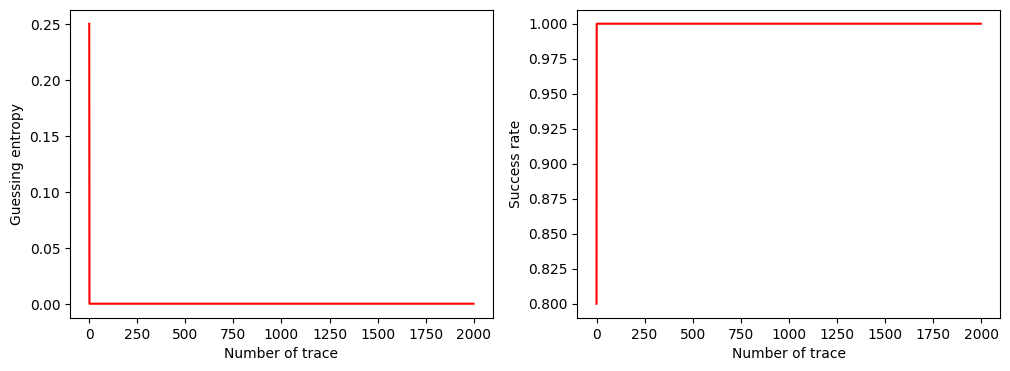

In [4]:
X_profiling, Y_profiling, X_test, Y_test, c_profiling, c_test = load_CW_Source(
        in_file=profiling_Data_path,
        sec=18000,  # Fixed security parameter from original implementation
)

#/* tweak is public*/
updatedTweak=([0xf8, 0xa7, 0x4e, 0xaa, 0x27, 0xb0, 0x83, 0x43, 0xe4, 0x90, 0x98, 0x8e, 0x53, 0xfa, 0x94, 0xfc,
0x1, 0xa1, 0x5c, 0xdf, 0x6c, 0xda, 0x21, 0x6, 0xc, 0x8e, 0xe2, 0xb9, 0x7e, 0x68, 0xce, 0x81])#/* tweak is public*/

scaler = preprocessing.StandardScaler()
X_profiling = scaler.fit_transform(X_profiling)
X_test = scaler.transform(X_test)

scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X_profiling = scaler.fit_transform(X_profiling)
X_test = scaler.transform(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]))



model = cnn_classifier(input_size=500)
model.load_weights(model_path+model_name)

print("\n############### Starting Predictions #################\n")
real_Roundkey= 0x48
predictions = model.predict(X_test)

print("\n############### Starting Attack on Test Set #################\n")
plot_guessing_entropy(predictions, real_Roundkey, c_test,updatedTweak)


<b>Source Model -Target

In [5]:
# Main parameter initialization
model_path = './Model/'
model_name = 'TK1=0xdf.h5'
profiling_Data_path='./Dataset/TK1=0xdf,TK2=0xab/'
Target_Data_path='./Dataset/TK1=0xe5,TK2=0x94/'

(20000, 500) (20000,) (20000, 16)

############### Starting Predictions #################

(20000, 256) (20000, 500) (20000, 16)

############### Starting Attack on Test Set #################



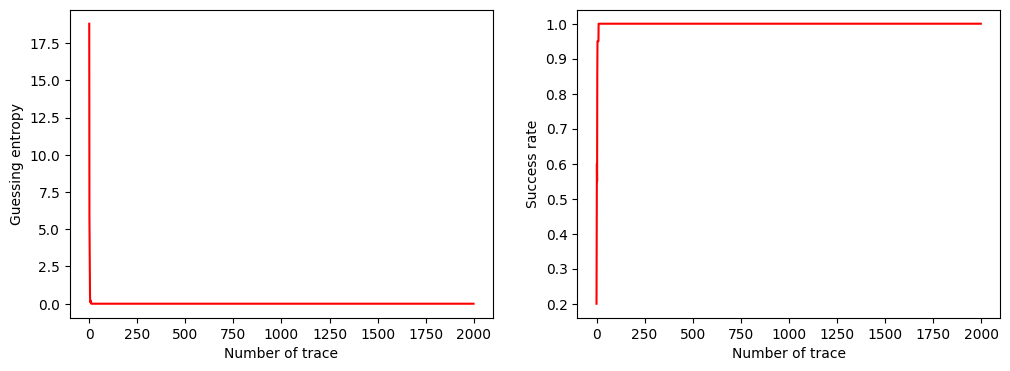

In [6]:
X_profiling, _, _, _,_, _ = load_CW_Source(
        in_file=profiling_Data_path,
        sec=18000,  # Fixed security parameter from original implementation
)

X_attack, Y_attack, c_attack = load_CW_Target(
        in_file=Target_Data_path,
)
#/* tweak is public*/
updatedTweak=([0x1f, 0x4d, 0xcf, 0xe6, 0x3, 0x57, 0xc, 0xf6, 0x4b, 0xed, 0xf9, 0x49, 0x30, 0x63, 0x5b, 0x7b,
0xbc, 0xb8, 0x6f, 0x38, 0xfa, 0xe9, 0x89, 0x3a, 0x6e, 0x6c, 0x22, 0xe7, 0x3d, 0x2a, 0x51, 0x58])

scaler = preprocessing.StandardScaler()
X_profiling = scaler.fit_transform(X_profiling)
X_attack = scaler.transform(X_attack)

scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X_profiling = scaler.fit_transform(X_profiling)
X_attack = scaler.transform(X_attack)
X_attack = X_attack.reshape((X_attack.shape[0], X_attack.shape[1]))



model = cnn_classifier(input_size=500)
model.load_weights(model_path+model_name)

print("\n############### Starting Predictions #################\n")
real_Roundkey= 0x48
predictions = model.predict(X_attack)
print(predictions.shape,X_attack.shape,c_attack.shape)

print("\n############### Starting Attack on Test Set #################\n")
plot_guessing_entropy(predictions, real_Roundkey, c_attack,updatedTweak)